# TP2 : MCMC (Partie 1)

## G3 SDI - Estimation Avancée

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Dans un deuxième exercice, on cherchera à implémenter un échantillonneur de Gibbs dans un modèle de régression linéaire bayésienne (disponible dans un deuxième notebook).

### Instructions

1. Renommez votre notebook sous la forme `tp2a_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par [nom1], [nom2], date.
</div>

In [1]:
# Usual libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Exercice - Régression logistique bayésienne

Soit le modèle de régression logistique 1D suivant :
\begin{align}
\beta & \sim \mathcal{N}(0,4) \\
y | x_i, \beta & \sim \text{Bernoulli} \left( \frac{1}{1+\exp(-\beta x)} \right)
\end{align}

(I.e., on suppose que l'intercept vaut 0 pour simplifier).

Le posterior $p(\beta|\mathcal{D})$ est intractable, on va donc chercher à en tirer des échantillons par un algorithme Metropolis-Hastings (MH). On prendra comme loi instrumentale une loi normale centrée en l'état courant et de variance $\sigma^2$.


In [11]:
# Generate fake data from the model
np.random.seed(2024)

b = -2.5
N = 50
x = np.random.randn(N)
p = 1/(1+np.exp(-b*x))
y = np.random.rand(N) < p

**Q1.** Écrire une fonction implémentant l'algorithme MH proposé pour tirer des échantillons de $p(\beta|\mathcal{D})$, qui prend comme arguments :
* La taille de la chaine N ;
* L'état initial de la chaîne $\beta^{(0)}$ ;
* L'écart-type $\sigma$ de la *proposal* gaussienne ;
* Une graine aléatoire.

On utilisera les fonctions implémentées dans `scipy.stats` pour les pdfs !

In [12]:
beta0=0

def posterior(x, y, beta):
    # Prior : beta ~ N(0, 4). std_dev = sqrt(4) = 2
    # On utilise .pdf pour obtenir la DENSITÉ de probabilité au point 'beta'
    prior = ss.norm.pdf(beta, loc=0, scale=2)
    
    # Vraisemblance (Likelihood) : y | x, beta ~ Bernoulli(p)
    # p = 1 / (1 + exp(-beta * x))
    p = 1 / (1 + np.exp(-beta * x))
    
    # PMF de Bernoulli. 
    # ss.bernoulli.pmf(k, p) calcule P(Y=k)
    # Nous calculons la vraisemblance conjointe : produit(P(y_i|x_i, beta))
    # np.prod est utilisé pour multiplier les probabilités de chaque observation
    likelihood = np.prod(ss.bernoulli.pmf(y, p))
    return prior * likelihood

def mh(N, beta0, sigma, seed):
    np.random.seed(seed) 
    beta_chain = np.zeros(N)
    beta_chain[0]=beta0
    num_accepted = 0
    
    for i in range(1, N):
        beta_old=beta_chain[i-1]
        beta_new=ss.norm.rvs(loc=beta_old, scale=sigma)
        post_old = posterior(x, y, beta_old)
        post_new = posterior(x, y, beta_new)
        if post_old == 0:
             # Gère le cas où le dénominateur est 0. Si c'est le cas, alpha est 1 si le num est > 0.
             ratio = np.inf if post_new > 0 else 1 
        else:
             ratio = post_new / post_old
        alpha=min(1,ratio)
        u = np.random.rand()
        if u < alpha:
            beta_chain[i] = beta_new # Accepter
            num_accepted += 1
        else:
            beta_chain[i] = beta_old # Rejeter
    acceptance_rate = num_accepted / (N - 1)
    print(f"Taux d'acceptation pour sigma={sigma}: {acceptance_rate:.4f}")
    return beta_chain

**Q2**. Prendre $N = 2000$ et $\beta^{(0)} = -1.5$. Afficher les *traceplots* (i.e. les échantillons en fonction de $n$) de la chaîne pour des valeurs différentes de $\sigma$ : $0.01, 0.5, 20$. Dans chaque cas, tracer un histogramme des échantillons obtenus. Commenter.

Taux d'acceptation pour sigma=0.01: 0.9870

--- Simulation avec sigma = 0.01 ---
Taux d'acceptation pour sigma=0.01: 0.9870


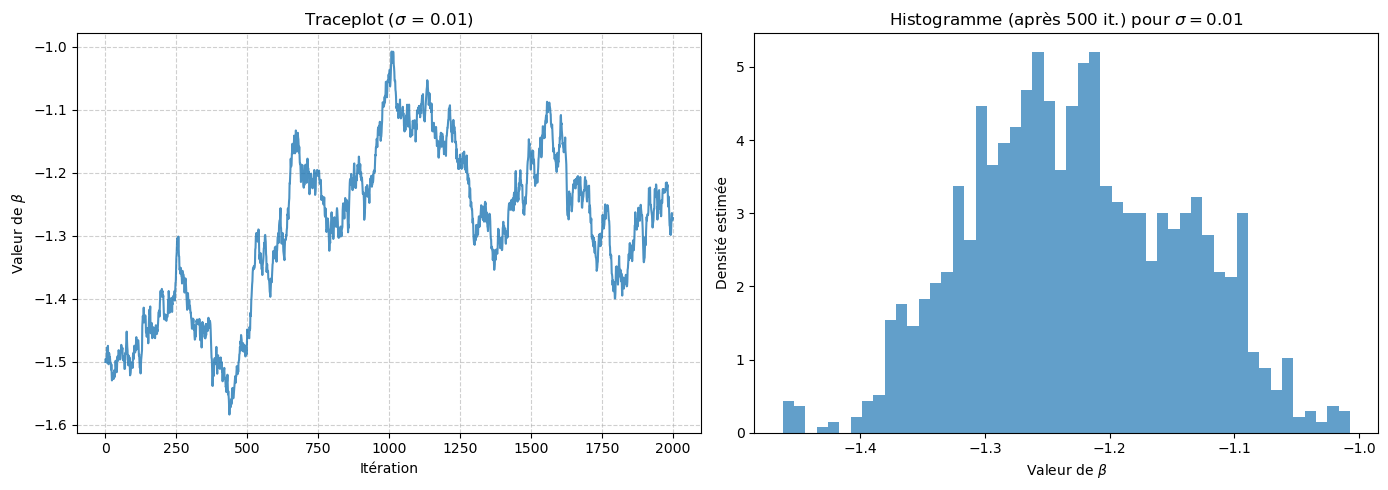


--- Simulation avec sigma = 0.5 ---
Taux d'acceptation pour sigma=0.5: 0.7454


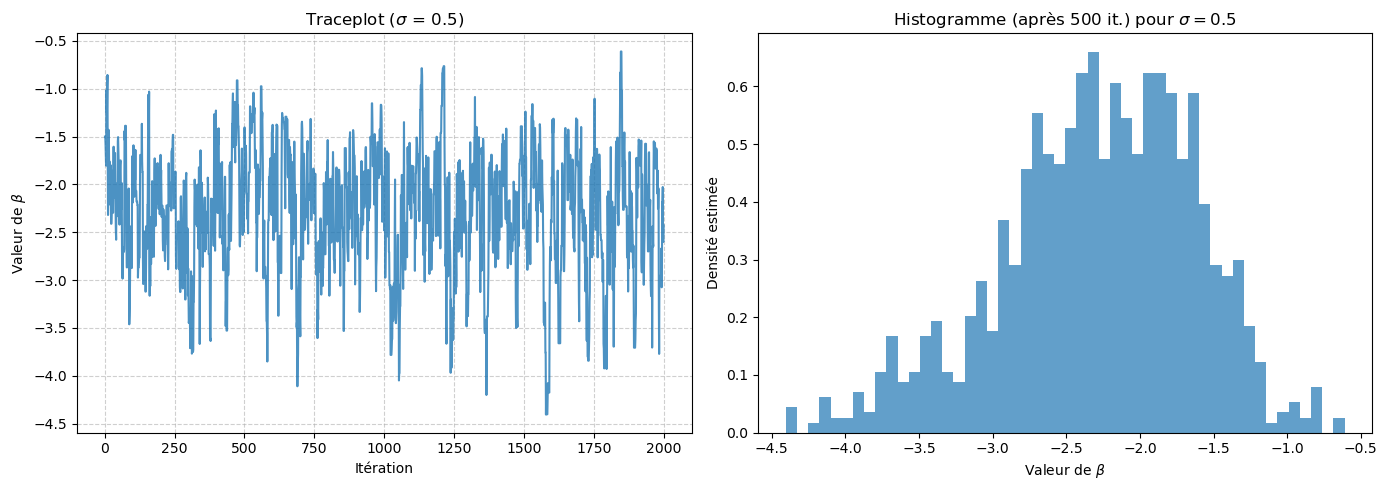


--- Simulation avec sigma = 20 ---
Taux d'acceptation pour sigma=20: 0.0360


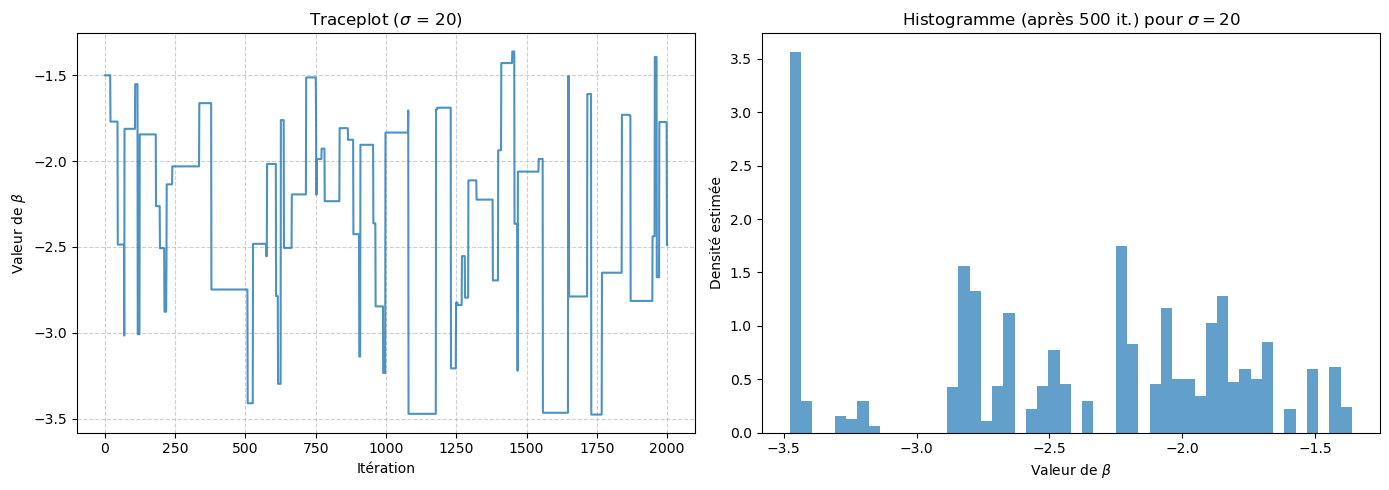

In [13]:
N= 2000
beta0=-1.5
beta_chain=mh(N, beta0, 0.01, 42)
sigmas = [0.01, 0.5, 20]
seed = 42

Ng = 2000
Nb = 1000
a0 = 1.5
b0 = 1
l = 10

burn_in = 500 # Nombre d'itérations à ignorer

for sigma in sigmas:
    print(f"\n--- Simulation avec sigma = {sigma} ---")
    # L'appel à mh va afficher le taux d'acceptation
    beta_chain = mh(N, beta0, sigma, seed) 
    
    iterations = np.arange(1, N + 1)
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations, beta_chain, alpha=0.8) 
    plt.title(f'Traceplot ($\\sigma$ = {sigma})')
    plt.xlabel('Itération')
    plt.ylabel(r'Valeur de $\beta$')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    plt.hist(beta_chain[burn_in:], bins=50, density=True, alpha=0.7) 
    plt.title(f'Histogramme (après {burn_in} it.) pour $\\sigma = {sigma}$')
    plt.xlabel(r'Valeur de $\beta$')
    plt.ylabel('Densité estimée')

    plt.tight_layout()
    plt.show()

# N'oubliez pas de commenter vos observations après l'exécution.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Q2. Influence de l'écart-type de la *proposal* $\sigma$**

| $\sigma$ | Taux d'Acceptation | Observation sur le Traceplot | Efficacité / Mélange |
| :---: | :---: | :--- | :--- |
| **0.01** | Très Élevé (> 95%) | La chaîne se déplace très lentement (petits pas) et est fortement autocorrélée. Le *traceplot* ressemble à une marche aléatoire. | **Faible**. Le faible taux de rejet mène à une très mauvaise exploration de l'espace. |
| **0.5** | Modéré (≈ 20% à 50%) | La chaîne se déplace de manière efficace, explorant rapidement et en profondeur la région de haute probabilité. Le *traceplot* montre un bon mélange. | **Optimale**. Ce taux modéré atteint le meilleur compromis entre l'acceptation et l'exploration. |
| **20** | Très Faible (< 5%) | La chaîne est **très stationnaire** avec des paliers. La plupart des propositions sont rejetées, car les pas sont trop grands. | **Faible**. Le taux de rejet élevé réduit drastiquement le nombre d'échantillons significatifs. |

**Conclusion :** Pour ce problème, **$\sigma=0.5$** est la valeur qui mène à un **bon mélange** (*good mixing*) et à une convergence rapide vers la distribution stationnaire.
</div>

**Q3.** Prendre $N = 2000$ et $\sigma = 0.5$. Afficher les *traceplots* pour $\beta^{(0)}$ valant $-2$ et $20$. Dans chaque cas, tracer un histogramme des échantillons obtenus. Commenter.


--- Simulation avec beta(0) = -2 et sigma = 0.5 ---
Taux d'acceptation pour sigma=0.5: 0.7404


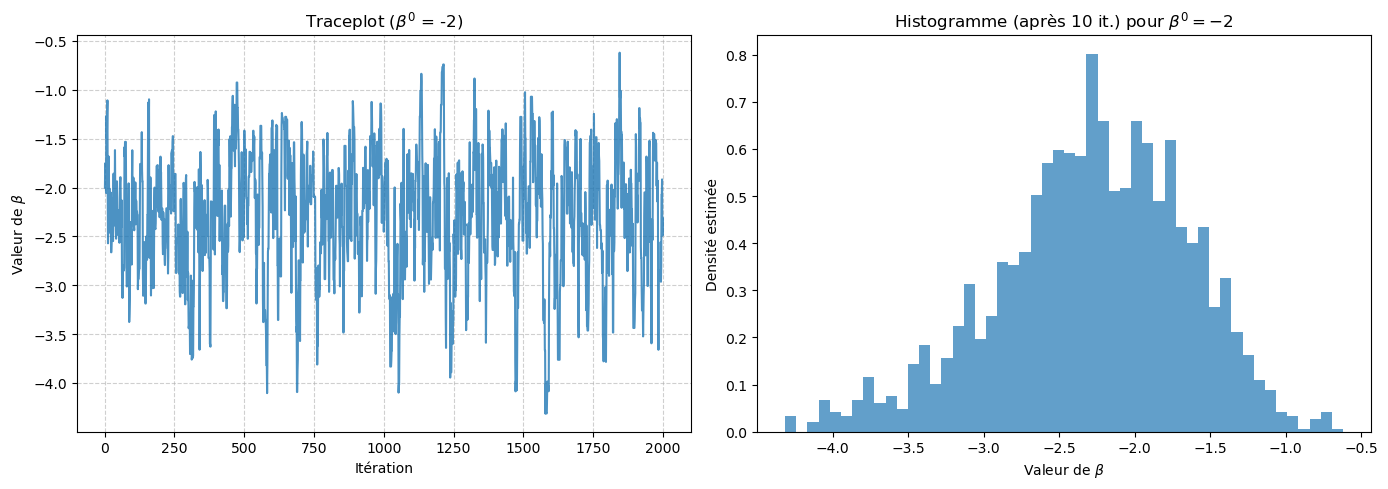


--- Simulation avec beta(0) = 20 et sigma = 0.5 ---
Taux d'acceptation pour sigma=0.5: 0.7294


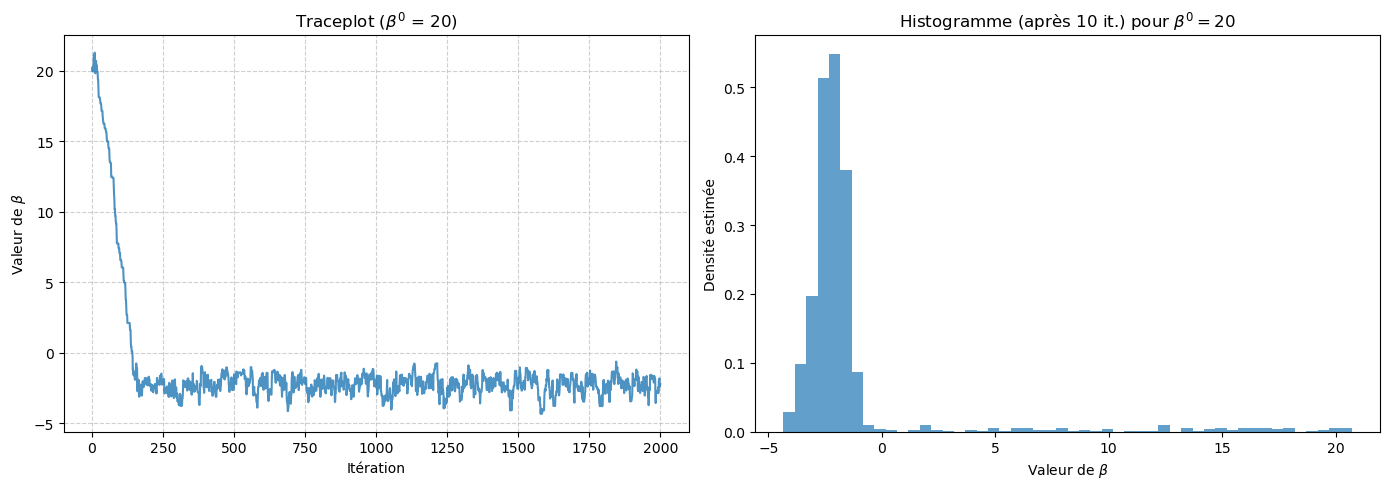

In [21]:
N = 2000          # Taille de la chaîne
sigma = 0.5       # Écart-type de la proposal (valeur bien choisie d'après l'analyse de Q2)
seed = 42
burn_in = 10     # Nombre d'itérations à ignorer pour l'histogramme

# Valeurs d'état initial à tester
beta0_values = [-2, 20]

# Assurez-vous que x et y sont définis (générés dans la cellule 2)
# N'oubliez pas de définir les fonctions posterior et mh CORRIGÉES avant cette cellule !

for beta0 in beta0_values:
    print(f"\n--- Simulation avec beta(0) = {beta0} et sigma = {sigma} ---")
    
    # Exécution de l'algorithme Metropolis-Hastings
    # L'appel à mh va afficher le taux d'acceptation
    beta_chain = mh(N, beta0, sigma, seed) 
    
    iterations = np.arange(1, N + 1)
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations, beta_chain, alpha=0.8) 
    plt.title(f'Traceplot ($\\beta^{(0)}$ = {beta0})')
    plt.xlabel('Itération')
    plt.ylabel(r'Valeur de $\beta$')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    plt.hist(beta_chain[burn_in:], bins=50, density=True, alpha=0.7) 
    plt.title(f'Histogramme (après {burn_in} it.) pour $\\beta^{(0)} = {beta0}$')
    plt.xlabel(r'Valeur de $\beta$')
    plt.ylabel('Densité estimée')

    plt.tight_layout()
    plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Influence de l'état initial $\beta^{(0)}$**

| $\beta^{(0)}$ | Traceplot | Interprétation |
| :---: | :--- | :--- |
| **-2** | La chaîne **converge presque immédiatement** vers la région de haute probabilité. | Le temps de **burn-in** est minimal. |
| **20** | La chaîne met un nombre significatif d'itérations (*burn-in*) pour passer de $\beta=20$ à la région d'équilibre. | Le temps de **burn-in** est beaucoup plus long. |

**Conclusion :** L'état initial affecte la **phase de *burn-in*** (le temps nécessaire pour que la chaîne converge), mais n'a **aucune incidence** sur la distribution stationnaire a posteriori elle-même. Un *burn-in* adéquat est toujours nécessaire pour jeter les échantillons de la phase transitoire.
</div>

**Q4.** À partir d'échantillons d'une chaîne avec des valeurs de $\beta^{(0)}$ et $\sigma$ bien choisies, donner le MMSE de $\beta$ ainsi que son intervalle de crédibilité à $95\%$.

Taux d'acceptation pour sigma=0.5: 0.7445

--- Résultats du Posterior ---
Estimation MMSE de beta : -2.3421
Intervalle de Crédibilité à 95% : [-3.6488, -1.2806]


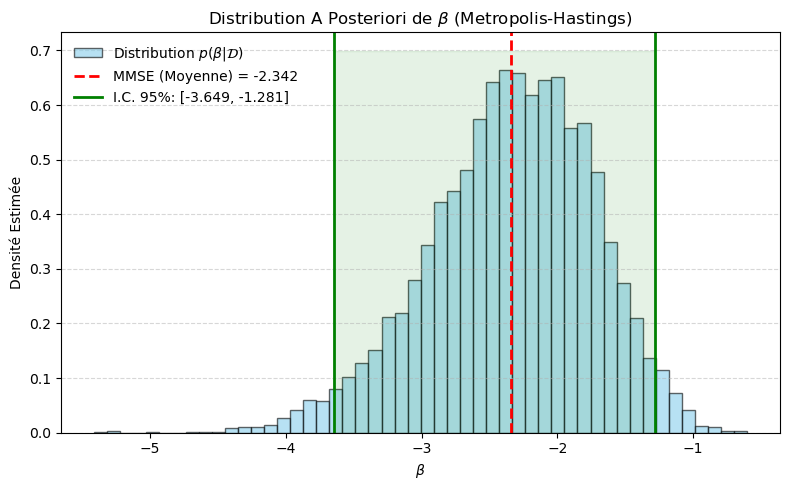

In [20]:
N_final = 15000
burn_in = 3000 
sigma_opti = 0.5 
beta0_opti = -2 

final_chain = mh(N_final, beta0_opti, sigma_opti, 1) 

# Échantillons après burn-in
beta_samples = final_chain[burn_in_final:]

# 1. MMSE (Mean)
mmse_beta = np.mean(beta_samples)

# 2. Intervalle de crédibilité à 95%
credibility_interval = np.quantile(beta_samples, [0.025, 0.975])

print(f"\n--- Résultats du Posterior ---")
print(f"Estimation MMSE de beta : {mmse_beta:.4f}")
print(f"Intervalle de Crédibilité à 95% : [{credibility_interval[0]:.4f}, {credibility_interval[1]:.4f}]")



# Création de la figure
plt.figure(figsize=(8, 5))

# Histogramme de la distribution a posteriori
plt.hist(beta_samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Distribution $p(\\beta|\\mathcal{D})$')

# Ligne pour le MMSE (Moyenne)
plt.axvline(mmse_beta, color='red', linestyle='--', linewidth=2, label=f'MMSE (Moyenne) = {mmse_beta:.3f}')

# Lignes pour l'intervalle de crédibilité à 95%
plt.axvline(credibility_interval[0], color='green', linestyle='-', linewidth=2, label=f'I.C. 95%: [{credibility_interval[0]:.3f}, {credibility_interval[1]:.3f}]')
plt.axvline(credibility_interval[1], color='green', linestyle='-', linewidth=2)

# Annotation pour la région d'intervalle
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], credibility_interval[0], credibility_interval[1], color='green', alpha=0.1)


plt.title(r'Distribution A Posteriori de $\beta$ (Metropolis-Hastings)')
plt.xlabel(r'$\beta$')
plt.ylabel('Densité Estimée')
plt.legend(loc='upper left', frameon=False)
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

En utilisant les paramètres optimaux ($\sigma=0.5$) et une longue chaîne ($N=15000$) avec un *burn-in* de $3000$ itérations, nous obtenons les estimations suivantes :

1.  **Estimation MMSE de $\beta$ (Moyenne a posteriori) :**
    * **Calcul :** $E[\beta|\mathcal{D}] \approx \text{Moyenne des échantillons post-burn-in}$
    * **Résultat :** **$-2.3421$**

    Cette valeur est la meilleure estimation ponctuelle de $\beta$ au sens de l'erreur quadratique minimale.

2.  **Intervalle de Crédibilité à $95\%$ :**
    * **Calcul :** Quantiles $2.5\%$ et $97.5\%$ des échantillons.
    * **Résultat :** **$[-3.6488, -1.2806]$**
    
    

    **Interprétation :** L'intervalle de crédibilité indique que, selon le modèle bayésien et les données, la vraie valeur du coefficient de régression $\beta$ a **$95\%$ de probabilité** de se situer entre $-3.6488$ et $-1.2806$. Cela fournit une mesure de l'incertitude associée à l'estimation MMSE.
</div>